In [1]:
# initiation date: 2023-03-27

import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import constrNMPy
from pytensor import tensor as pt 
import os 

print(f"Running on PyMC v{pm.__version__}")

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# os.getcwd() 
os.chdir('/Users/abel/Desktop/Junior/CogMod/Assignments/H3') # change the working directory to the folder where the data is stored

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.1.2


In [2]:
az.style.use("arviz-white")

# load the data from the csv file and take a look
dt = pd.read_csv('homework3_q3.csv', header = 0 ) # load the data from the csv file
dt # take a look at the data
scores = dt.values[:,0:-1] # extract the scores
scores

array([[1, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

# 问题三

在two-country quiz problem中，一组数据为'homework3_q3.csv'。对题目和答题者有以下两种假设：
* $H_1$：答题者包括泰国人和摩尔多瓦人，题目除了泰国历史题和摩尔多瓦历史题外，还有英国历史题。设泰国人和摩尔多瓦人对英国历史题的答题正确率均为$\gamma$，已知泰国人和摩尔多瓦人回答英国历史题的正确率均低于回答本国历史题的正确率($\gamma < \alpha$)；
* $H_2$：题目包括泰国历史题和摩尔多瓦历史题，答题者除了泰国人和摩尔多瓦人外，还有英国人。设英国人对泰国历史题和摩尔多瓦历史题的答题正确率均为$\zeta$，已知英国人回答两国历史题的正确率均低于本国人回答本国题目的正确率 ($\zeta < \alpha$)
* 泰国人和摩尔多瓦人答对方题目的正确率为 $\beta$ 
* $\beta < \alpha, \gamma < \alpha, \zeta < \alpha$

### Q1
请为$\gamma$和$\zeta$设置恰当的先验分布，并画出$H1$和$H_2$的graphical model

In [3]:
[quizn, personn] = [8, 14]

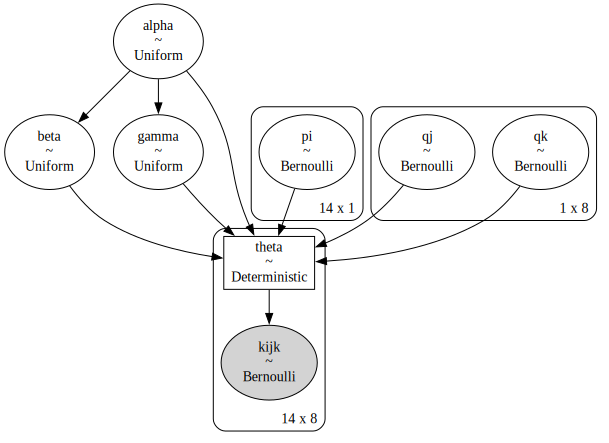

In [4]:
with pm.Model() as q3H1_Model:
    # prior
    alpha = pm.Uniform("alpha", lower=0., upper=1.)
    beta = pm.Uniform("beta", lower=0., upper=alpha)
    gamma = pm.Uniform("gamma", lower=0., upper=alpha)

    # set p of xi to be 1 for the first row and 0.5 for the rest
    pi = pm.Bernoulli("pi", p=np.array([1]+[0.5]*(personn-1)).reshape(-1, 1), shape=(personn, 1)) # shape = (personn, 1)
    qj = pm.Bernoulli("qj", p=0.5, shape=(1, quizn)) # shape = (1, quizn) if the question is the same country or not
    qk = pm.Bernoulli("qk", p=0.5, shape=(1, quizn)) # shape = (1, quizn) if the question is english or not
    # # accuracy prior
    theta = pm.Deterministic("theta", pt.switch(qk, gamma, pt.switch(pt.eq(pi,qj), alpha, beta))) # shape = (personn, quizn)
    
    # observed
    kijk = pm.Bernoulli("kijk", p=theta, observed=scores) # shape = (personn, quizn)
    
pm.model_to_graphviz(q3H1_Model)

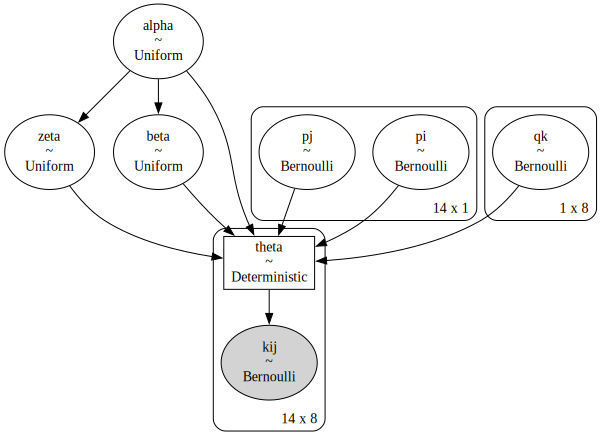

In [5]:
with pm.Model() as q3H2_Model:
    # prior
    alpha = pm.Uniform("alpha", lower=0., upper=1.)
    beta = pm.Uniform("beta", lower=0., upper=alpha)
    zeta = pm.Uniform("zeta", lower=0., upper=alpha)

    # set p of xi to be 1 for the first row and 0.5 for the rest
    pi = pm.Bernoulli("pi", p=0.5, shape=(personn, 1)) #
    pj = pm.Bernoulli("pj", p=0.5, shape=(personn, 1)) # shape = (personn, 1)
    qk = pm.Bernoulli("qk", p=np.array([1]+[0.5]*(quizn-1)).reshape(1, -1), shape=(1, quizn)) # shape = (1, quizn) if the question is english or not
    # # accuracy prior
    theta = pm.Deterministic("theta", pt.switch(pj, zeta, pt.switch(pt.eq(pi,qk), alpha, beta))) # shape = (personn, quizn)
    
    # observed
    kijk = pm.Bernoulli("kij", p=theta, observed=scores) # shape = (personn, quizn)
    
pm.model_to_graphviz(q3H2_Model)

### Q2
对本题数据分别运行$H_1$和$H_2$对应的模型，请在答案中
1. 对$H_1$，分别画出$\alpha$、$\beta$和$\gamma$的后验分布；
2. 对$H_2$，分别画出$\alpha$、$\beta$和$\zeta$的后验分布；
3. 报告两个模型相应的convergence指标。

In [5]:
with q3H1_Model:
    step = pm.Slice([alpha, beta, gamma])
    trace_H1 = pm.sample(draws=5000,tune=1000, step=step)
    pm.compute_log_likelihood(trace_H1)

az.summary(trace_H1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [gamma]
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [gamma]
>BinaryGibbsMetropolis: [pi, qj, qk]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 60 seconds.
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"pi[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,20000.0,20000.0,NaN
"pi[1, 0]",0.723,0.448,0.000,1.000,0.017,0.012,678.0,678.0,1.0
"pi[2, 0]",0.336,0.472,0.000,1.000,0.020,0.014,537.0,537.0,1.0
"pi[3, 0]",0.332,0.471,0.000,1.000,0.021,0.015,490.0,490.0,1.0
"pi[4, 0]",0.734,0.442,0.000,1.000,0.015,0.010,902.0,902.0,1.0
...,...,...,...,...,...,...,...,...,...
"theta[13, 3]",0.245,0.117,0.000,0.422,0.002,0.001,5334.0,4314.0,1.0
"theta[13, 4]",0.293,0.164,0.000,0.589,0.002,0.002,4892.0,5574.0,1.0
"theta[13, 5]",0.215,0.155,0.000,0.487,0.003,0.002,2193.0,2905.0,1.0
"theta[13, 6]",0.249,0.137,0.011,0.478,0.002,0.001,6983.0,9829.0,1.0


In [11]:
posterior_psiN = trace_H1.posterior["psiN"].values.flatten()    # read posterior samples and flatten
az.plot_kde(posterior_psiN, ax=axes[0])
axes[0].hist(posterior_psiN, bins=100, density=1, alpha=0.3)
axes[0].set_xlabel("Rate")
axes[0].set_ylabel("Posterior Density")

az.plot_posterior(trace1, var_names=["psiN"], ax=axes[1], color="#87ceeb")
plt.tight_layout();

KeyError: 'psiN'

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_4040/1069099139.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5);


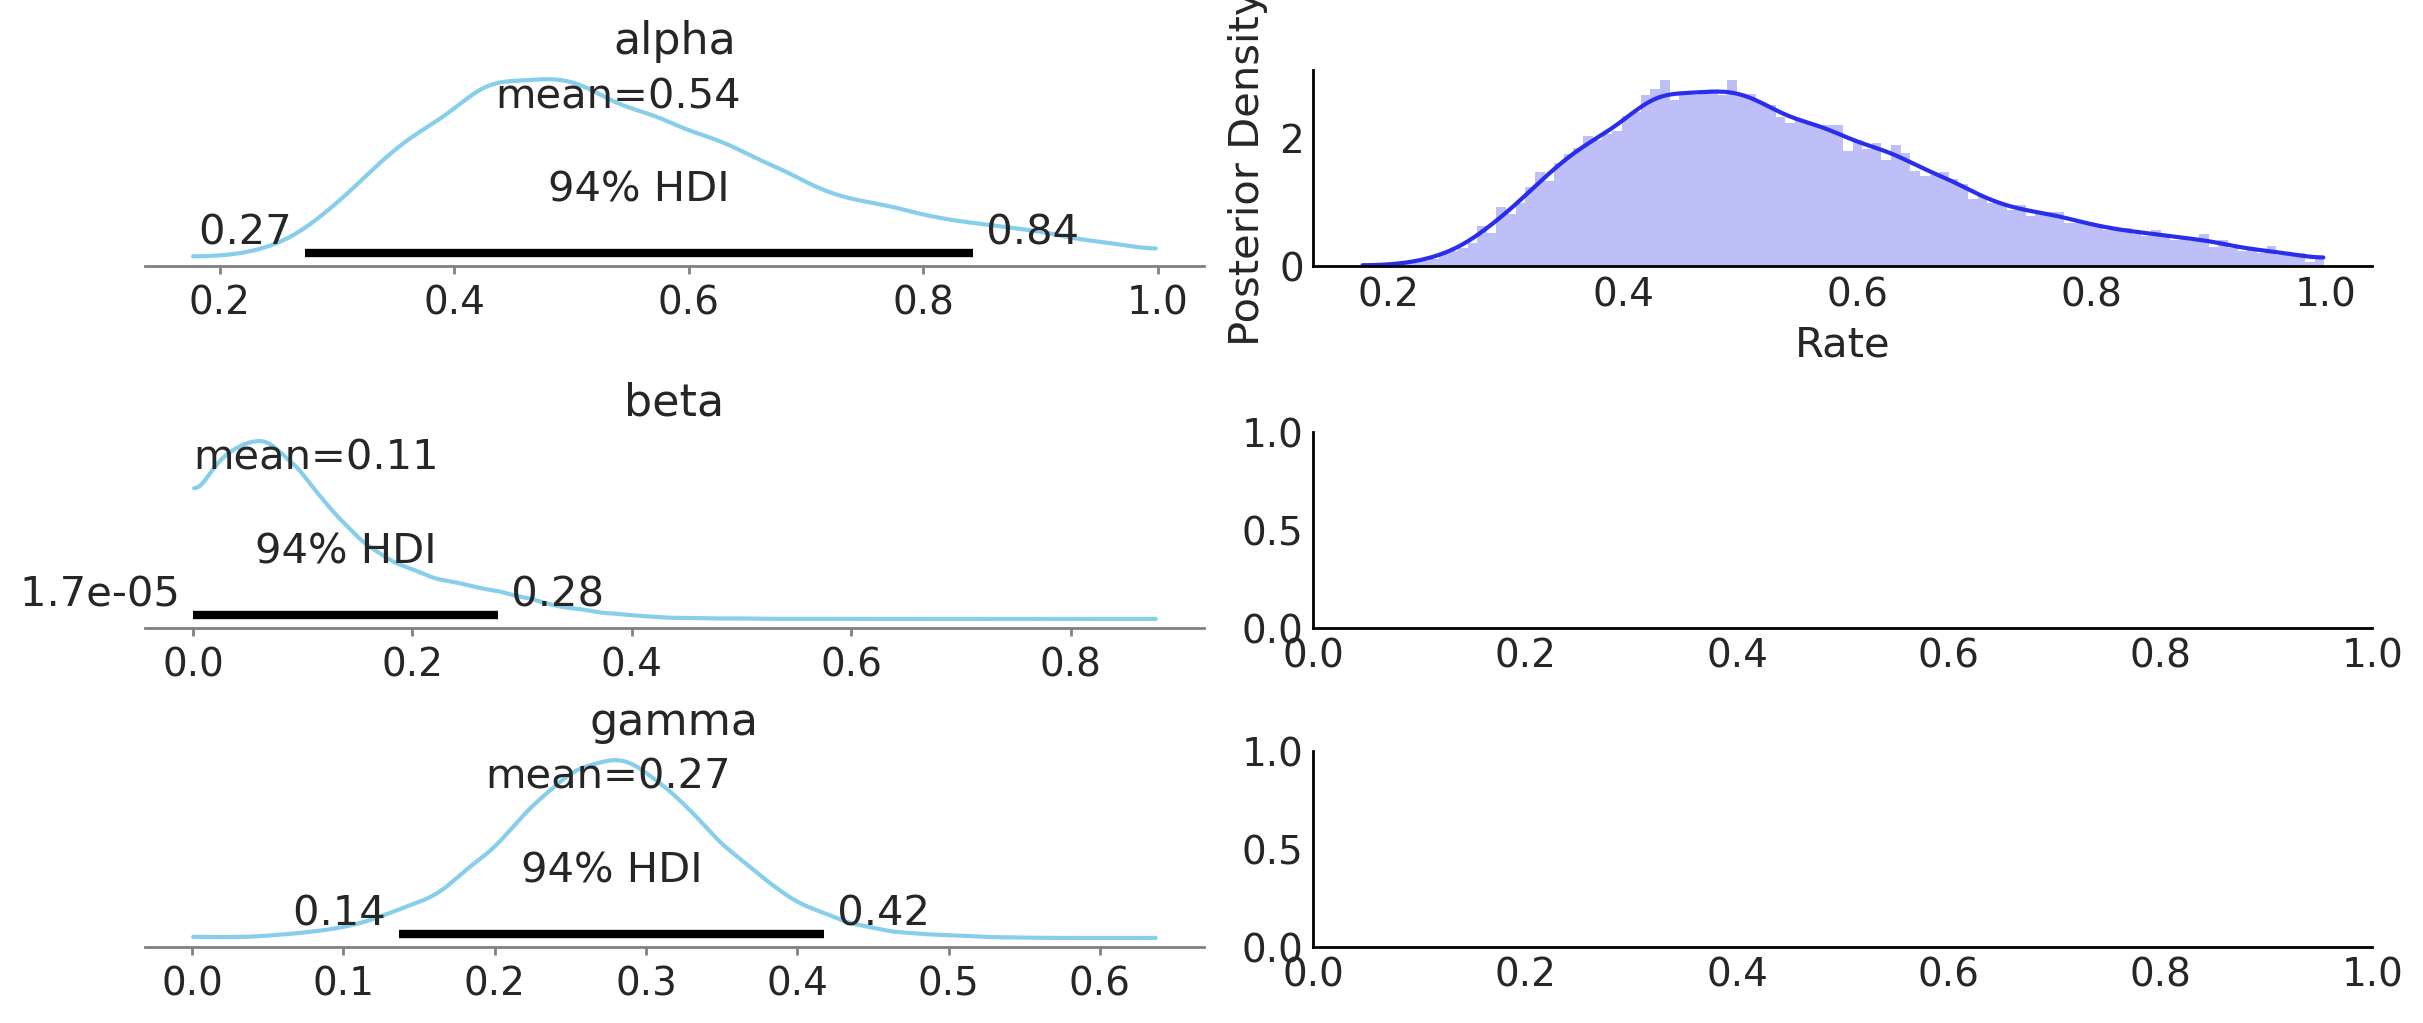

In [12]:
# plot the posterior distribution of alpha, beta, gamma
_, axes = plt.subplots(3,2, figsize = [12,5])

[posterior_alpha, posterior_beta, posterior_gamma] = [trace_H1.posterior["alpha"].values.flatten(), trace_H1.posterior["beta"].values.flatten(), trace_H1.posterior["gamma"].values.flatten()]
az.plot_kde(posterior_alpha, ax=axes[0,1])
axes[0,1].hist(posterior_alpha, bins=100, density=1, alpha=0.3)
axes[0,1].set_xlabel("Rate")
axes[0,1].set_ylabel("Posterior Density")


az.plot_posterior(trace_H1, var_names=["alpha"], ax=axes[0,0], color="#87ceeb")
az.plot_posterior(trace_H1, var_names=["beta"], ax=axes[1,0], color="#87ceeb")
az.plot_posterior(trace_H1, var_names=["gamma"], ax=axes[2,0], color="#87ceeb")

plt.subplots_adjust(hspace=0.5);

In [110]:
with q3H2_Model:
    step = pm.Slice([alpha, beta, zeta])
    trace_H2 = pm.sample(draws=2000,tune=1000, step=step)
    pm.compute_log_likelihood(trace_H2)

az.summary(trace_H2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [zeta]
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [zeta]
>BinaryGibbsMetropolis: [pi, pj, qk]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"pi[0, 0]",0.989,0.106,1.000,1.000,0.005,0.004,456.0,8000.0,1.01
"pi[1, 0]",0.982,0.132,1.000,1.000,0.005,0.003,733.0,8000.0,1.00
"pi[2, 0]",0.017,0.130,0.000,0.000,0.005,0.004,678.0,678.0,1.00
"pi[3, 0]",0.010,0.100,0.000,0.000,0.005,0.004,399.0,399.0,1.01
"pi[4, 0]",0.981,0.137,1.000,1.000,0.006,0.004,540.0,8000.0,1.01
...,...,...,...,...,...,...,...,...,...
"theta[13, 3]",0.071,0.049,0.003,0.144,0.001,0.001,3652.0,4267.0,1.00
"theta[13, 4]",0.071,0.051,0.003,0.144,0.001,0.001,3658.0,4267.0,1.00
"theta[13, 5]",0.071,0.053,0.004,0.145,0.001,0.001,3676.0,4267.0,1.00
"theta[13, 6]",0.071,0.053,0.004,0.145,0.001,0.001,3676.0,4267.0,1.00


/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_43621/3477965160.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5);


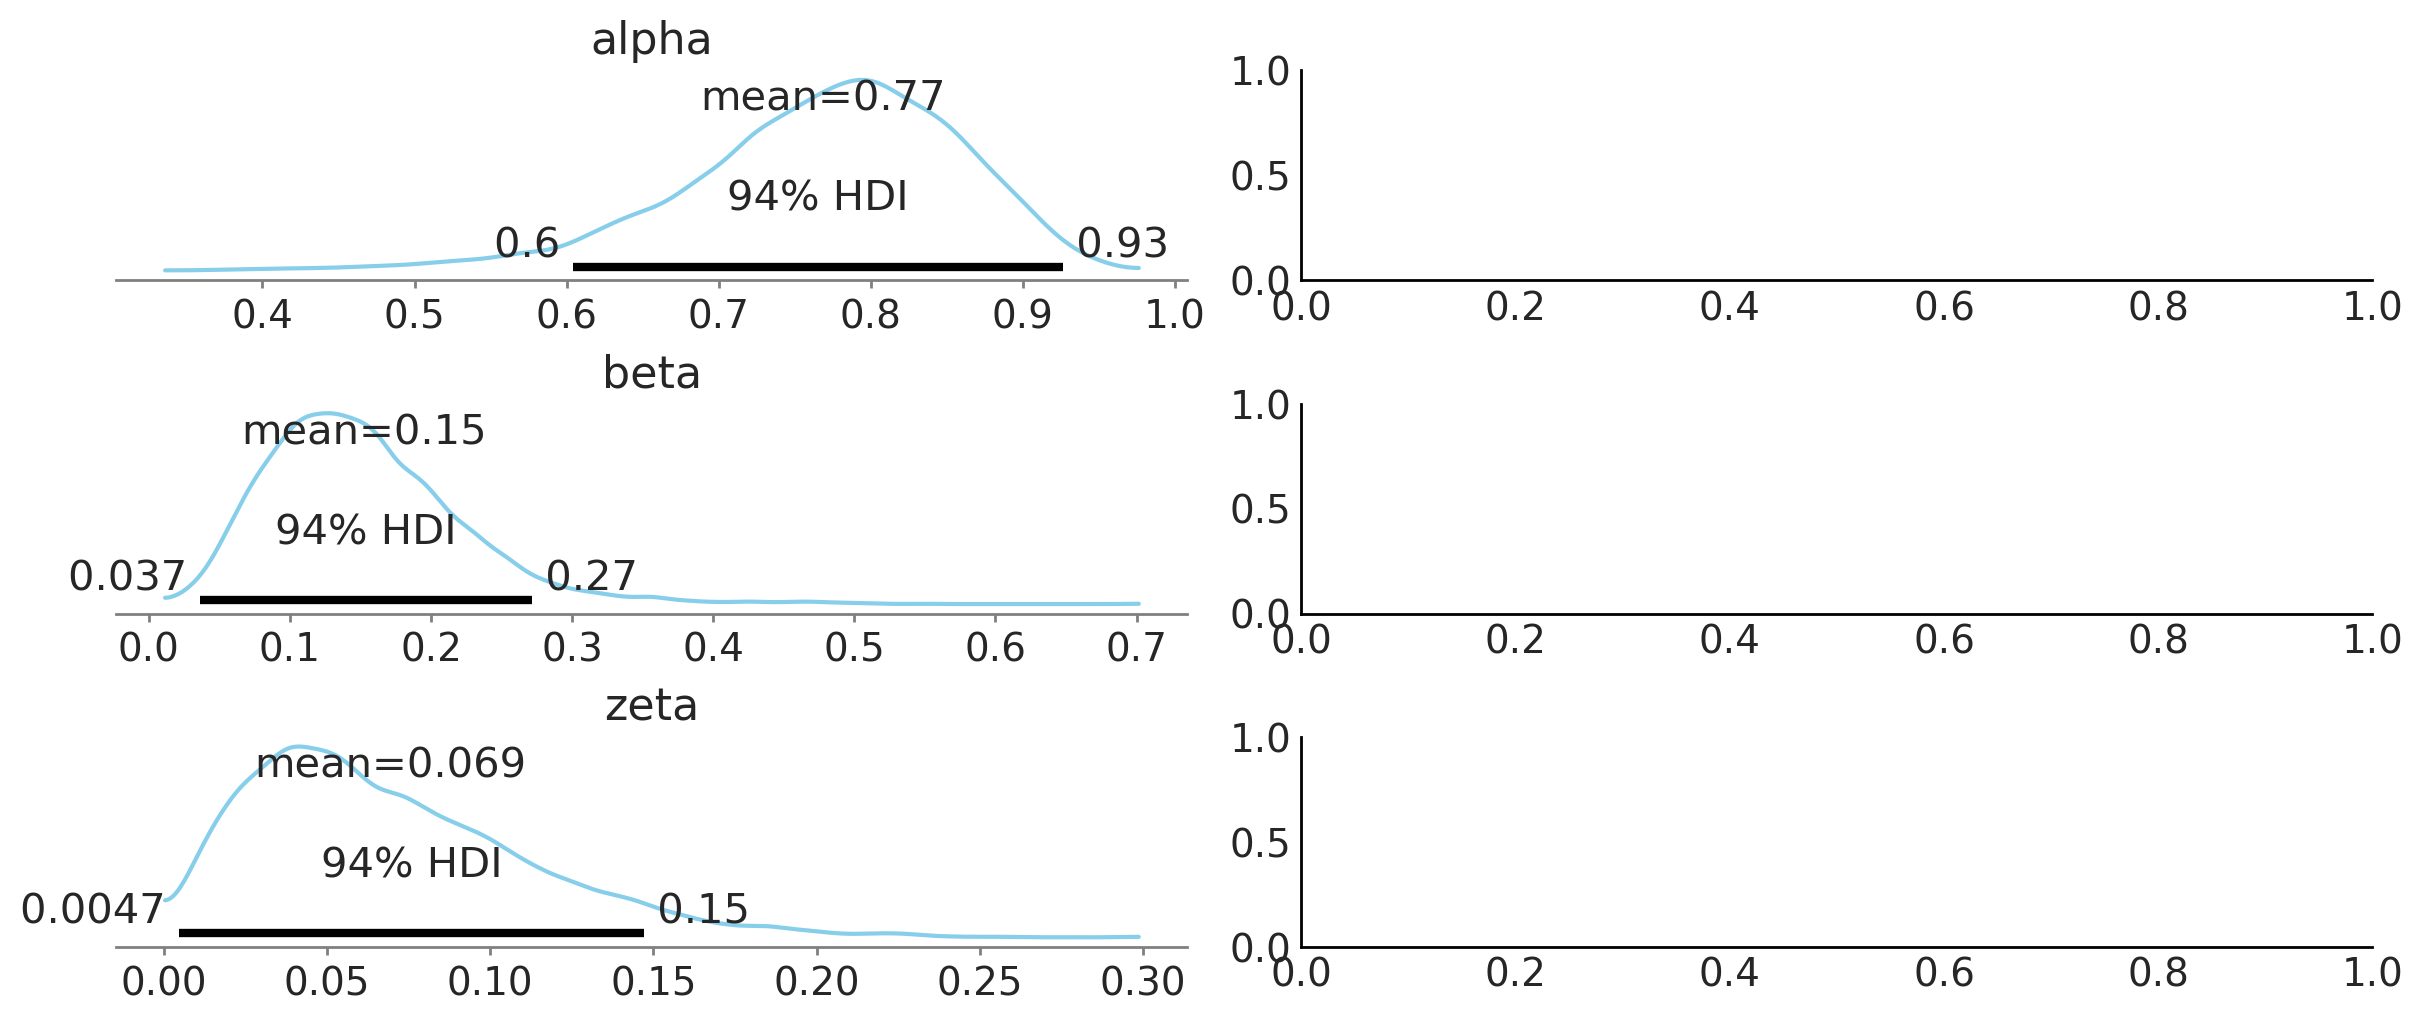

In [62]:
# plot the posterior distribution of alpha, beta, zeta
_, axes = plt.subplots(3,2, figsize = [12,5])

az.plot_posterior(trace_H2, var_names=["alpha"], ax=axes[0,0], color="#87ceeb")
az.plot_posterior(trace_H2, var_names=["beta"], ax=axes[1,0], color="#87ceeb")
az.plot_posterior(trace_H2, var_names=["zeta"], ax=axes[2,0], color="#87ceeb")

plt.subplots_adjust(hspace=0.5);

### Q3
请比较$H_1$和$H_2$对应模型WAIC，并简单解释比较结果。

In [77]:
?pm.waic

Signature: pm.waic(data, pointwise=None, var_name=None, scale=None, dask_kwargs=None)
Docstring:
Compute the widely applicable information criterion.

Estimates the expected log pointwise predictive density (elpd) using WAIC. Also calculates the
WAIC's standard error and the effective number of parameters.
Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1004.2316

Parameters
----------
data: obj
    Any object that can be converted to an :class:`arviz.InferenceData` object.
    Refer to documentation of :func:`arviz.convert_to_inference_data` for details.
pointwise: bool
    If True the pointwise predictive accuracy will be returned. Defaults to
    ``stats.ic_pointwise`` rcParam.
var_name : str, optional
    The name of the variable in log_likelihood groups storing the pointwise log
    likelihood data to use for waic computation.
scale: str
    Output scale for WAIC. Available options are:

    - `log` : (default) log-score
    - `negative_log` :

In [14]:
with q3H1_Model:
    pm.compute_log_likelihood(trace_H1)

ValueError: ['log_likelihood'] group(s) already exists.

In [15]:
# compute the WAIC for H1

waic_H1 = pm.waic(trace_H1)

/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [111]:
q3h1_idata = az.convert_to_inference_data(trace_H1)
q3h2_idata = az.convert_to_inference_data(trace_H2)

In [119]:
waic_h1 = az.waic(q3h1_idata, pointwise=True, scale="log")
waic_h2 = az.waic(q3h2_idata, pointwise=True, scale="log")

/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [120]:
# compare the two models
comparison = az.compare({"q3H1_Model": q3h1_idata, "q3H2_Model": q3h2_idata})

print(comparison)

/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


            rank   elpd_loo      p_loo  elpd_diff        weight        se  \
q3H2_Model     0 -45.188443  10.288901   0.000000  1.000000e+00  6.291971   
q3H1_Model     1 -66.271665  12.726541  21.083222  1.953993e-13  4.600963   

                 dse  warning scale  
q3H2_Model  0.000000     True   log  
q3H1_Model  4.868925     True   log  


/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
